In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### Load Data

In [2]:
# transforms.Compose transformation steps in sequence.
# ToTensor() converts format to pytorch tensor
# Normalize first tuple Centers the pixel values to have a mean of 0.
# second tuple  Scales the values such that each channel has a standard deviation of 1.
# This normalization step results in pixel values being scaled to a range of approximately [-1, 1], 
# which can help improve training stability and speed.

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

In [3]:
batch_size = 4

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Show images
import matplotlib.pyplot as plt
import numpy as np

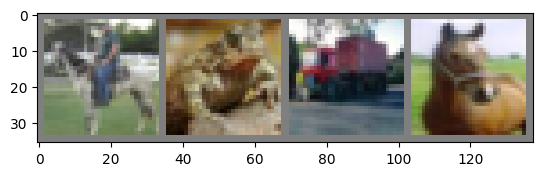

horse frog  truck horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5     #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
#random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define CNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # The nn takes 3-channel images
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
net = Net()

### Define Loss Function and Optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

### Train the Net

In [9]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data # data is a list of [inputs, labels]
        
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d} loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')

[1,  2000 loss: 2.084
[1,  4000 loss: 1.960
[1,  6000 loss: 1.939
[1,  8000 loss: 1.964
[1, 10000 loss: 1.915
[1, 12000 loss: 1.918
[2,  2000 loss: 1.924
[2,  4000 loss: 1.942
[2,  6000 loss: 1.920
[2,  8000 loss: 1.946
[2, 10000 loss: 1.951
[2, 12000 loss: 1.941
Finished Training


In [10]:
# Save model

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the Net on the Test Data

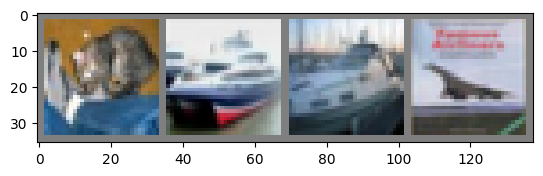

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
# Load the saved model. Just to illustrate
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [13]:
outputs = net(images)

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  dog   plane plane plane


In [15]:
correct = 0
total = 0

with torch.no_grad(): #since we're not training, we don't need to calculate the gradients for our outputs
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 26 %


Accuracy per class

In [16]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# No gradients needed:
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        #correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


In [17]:
correct_pred

{'plane': 633,
 'car': 83,
 'bird': 206,
 'cat': 152,
 'deer': 446,
 'dog': 149,
 'frog': 183,
 'horse': 380,
 'ship': 5,
 'truck': 451}

In [18]:
total_pred

{'plane': 1000,
 'car': 1000,
 'bird': 1000,
 'cat': 1000,
 'deer': 1000,
 'dog': 1000,
 'frog': 1000,
 'horse': 1000,
 'ship': 1000,
 'truck': 1000}

In [20]:
# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname:5s} is {accuracy:.1f} %")

Accuracy for class plane is 63.3 %
Accuracy for class car   is 8.3 %
Accuracy for class bird  is 20.6 %
Accuracy for class cat   is 15.2 %
Accuracy for class deer  is 44.6 %
Accuracy for class dog   is 14.9 %
Accuracy for class frog  is 18.3 %
Accuracy for class horse is 38.0 %
Accuracy for class ship  is 0.5 %
Accuracy for class truck is 45.1 %


Training on GPU

In [21]:
# To do that, we transfer the model onto the GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [40]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # data is a list of [inputs, labels]
        
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d} loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')

[1,  2000 loss: 1.943
[1,  4000 loss: 1.975
[1,  6000 loss: 1.947
[1,  8000 loss: 1.943
[1, 10000 loss: 1.933
[1, 12000 loss: 1.942
[2,  2000 loss: 1.954
[2,  4000 loss: 1.946
[2,  6000 loss: 1.936
[2,  8000 loss: 1.948
[2, 10000 loss: 1.951
[2, 12000 loss: 1.945
Finished Training


In [41]:
correct = 0
total = 0

with torch.no_grad(): #since we're not training, we don't need to calculate the gradients for our outputs
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 26 %


In [43]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# No gradients needed:
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        #correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


In [44]:
# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname:5s} is {accuracy:.1f} %")

Accuracy for class plane is 63.3 %
Accuracy for class car   is 8.3 %
Accuracy for class bird  is 20.6 %
Accuracy for class cat   is 15.3 %
Accuracy for class deer  is 44.6 %
Accuracy for class dog   is 14.9 %
Accuracy for class frog  is 18.3 %
Accuracy for class horse is 38.0 %
Accuracy for class ship  is 0.5 %
Accuracy for class truck is 45.1 %


The only difference is that the accuracy of the 'cat' class increased 0.1%.
That's because the net is very small

Changing the width of the net.

In [45]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # The nn takes 3-channel images
        # Only difference is that output argument is changed to 82
        self.conv1 = nn.Conv2d(3, 82, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(82, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [46]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 82, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(82, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [47]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # data is a list of [inputs, labels]
        
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d} loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')

[1,  2000 loss: 2.306
[1,  4000 loss: 2.306
[1,  6000 loss: 2.306
[1,  8000 loss: 2.306
[1, 10000 loss: 2.305
[1, 12000 loss: 2.305
[2,  2000 loss: 2.306
[2,  4000 loss: 2.306
[2,  6000 loss: 2.305
[2,  8000 loss: 2.306
[2, 10000 loss: 2.306
[2, 12000 loss: 2.306
Finished Training


I can kinda see how will the results look like from these loss values...